In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# ------------------ Configuration ------------------

# Load CSVs
predictions_baseline = pd.read_csv("Results/model_predictions.csv (252-window).csv")
predictions_chronos = pd.read_csv("Results/chronos(252-day).csv")
predictions_timesfm = pd.read_csv("Results/timesfm(252-day).csv")
predictions_uni2ts = pd.read_csv("Results/uni2ts(252-day)predictions.csv")

# Convert 'DlyCalDt' to datetime
for df in [predictions_baseline, predictions_chronos, predictions_timesfm, predictions_uni2ts]:
    df['DlyCalDt'] = pd.to_datetime(df['DlyCalDt'])

# Sort by date
for df in [predictions_baseline, predictions_chronos, predictions_timesfm, predictions_uni2ts]:
    df.sort_values(by=["DlyCalDt", "PERMNO"], inplace=True, ignore_index=True)

# Combine all predictions into a single DataFrame
exclude_columns = ['DlyCalDt', 'PERMNO', 'ExcessReturn']

baseline_cols = predictions_baseline.columns.tolist()
chronos_cols = [cols for cols in predictions_chronos.columns.tolist() if cols not in exclude_columns]
timesfm_cols = [cols for cols in predictions_timesfm.columns.tolist() if cols not in exclude_columns]
uni2ts_cols = [cols for cols in predictions_uni2ts.columns.tolist() if cols not in exclude_columns] 

# Concatenate along axis=1 (columns), aligned by index
combined_df = pd.concat([
    predictions_baseline[baseline_cols],
    predictions_chronos[chronos_cols],
    predictions_timesfm[timesfm_cols],
    predictions_uni2ts[uni2ts_cols]
], axis=1)

combined_df.rename(columns={
    'DlyCalDt': 'Date',
    'ExcessReturn': 'Actual'
}, inplace=True)

In [2]:
combined_df

,PERMNO,Date,Actual,Ridge,OLS,ElasticNet,Lasso,GLM,RF,NN1,...,y_chr_bolt_small,y_chr_bolt_base,y_chr_t5_tiny,y_chr_t5_mini,y_chr_t5_small,y_tfm1,y_tfm2,y_moirai_s,y_moirai_moe_s,y_moirai_moe_b
0,10138,2016-01-04,-0.018191,-0.004143,-0.004143,0.000625,0.000674,-0.004177,0.000407,0.000203,...,-0.001564,-0.001689,0.003099,0.001360,0.001157,-0.002102,-0.013468,-0.002219,-0.000939,-0.002451
1,17778,2016-01-04,-0.007616,-0.002580,-0.002580,0.000221,0.000626,-0.002273,0.000407,-0.000076,...,-0.001041,-0.001370,-0.001333,-0.000048,-0.001620,-0.001228,-0.017500,0.006807,-0.001220,0.004609
2,28388,2016-01-04,-0.015413,-0.005698,-0.005698,0.000952,0.000927,-0.005601,0.000407,-0.000602,...,0.000284,0.000514,0.002055,0.000463,0.000587,0.000246,-0.011218,-0.005661,0.002210,-0.000521
3,34746,2016-01-04,-0.027370,-0.002167,-0.002167,0.000934,0.000713,-0.001459,0.000407,0.002295,...,0.000553,0.000131,0.002393,0.002728,0.002003,-0.000967,-0.019544,0.004117,0.002983,0.006002
4,35044,2016-01-04,-0.016674,-0.001958,-0.001958,0.000539,0.000568,-0.001318,0.000407,0.005719,...,-0.000225,-0.000914,0.002093,0.001914,0.000308,-0.002593,-0.020761,0.032126,0.006111,0.005684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112395,86455,2024-12-31,0.000924,0.001271,0.001271,0.001255,0.000782,0.001768,0.000407,0.000248,...,0.000731,0.000555,0.000564,-0.001260,0.001696,0.000410,-0.005479,0.004775,0.005910,0.002849
112396,86755,2024-12-31,-0.008607,0.002545,0.002545,0.001563,0.000819,0.002505,0.000407,0.000234,...,0.000896,0.001230,0.002860,0.002112,0.000996,-0.000016,-0.009630,0.016519,0.001489,0.000947
112397,86868,2024-12-31,-0.001733,0.002049,0.002049,0.001675,0.000730,0.002527,0.000407,-0.001945,...,0.001620,0.001149,0.002565,0.000939,0.000575,0.001895,-0.007931,0.010327,0.002633,0.003929
112398,87267,2024-12-31,-0.002370,0.004601,0.004601,0.001591,0.001018,0.003958,0.000407,0.002246,...,-0.000135,0.000299,0.000366,-0.003324,0.000023,0.001402,-0.009405,0.003279,0.001094,0.002043


### Sharpe Ratio for actual returns: 0.4552


In [3]:

def build_long_short_portfolio(df, column_name, n=10):
    
    long_short_returns = []
    
    for date, group in df.groupby('Date'):
        sorted_group = group.sort_values(column_name, ascending=False)
        no_of_stocks = round((n/100)*len(sorted_group))
        top = sorted_group.head(no_of_stocks)
        bottom = sorted_group.tail(no_of_stocks)
        avg_return = top['Actual'].mean() - bottom['Actual'].mean()
        long_short_returns.append((date, avg_return))
    
    return pd.DataFrame(long_short_returns, columns=["Date", "Returns"])

In [4]:
model_cols = [
    'Ridge', 'OLS', 'ElasticNet', 'Lasso', 'GLM', 'RF',
    'NN1', 'NN2', 'NN3', 'NN4', 'NN5', 'GBRT',
    'y_chr_bolt_tiny', 'y_chr_bolt_mini', 'y_chr_bolt_small', 'y_chr_bolt_base',
    'y_chr_t5_tiny', 'y_chr_t5_mini', 'y_chr_t5_small',
    'y_tfm1', 'y_tfm2',
    'y_moirai_s', 'y_moirai_moe_s', 'y_moirai_moe_b'
]

portfolio_returns = {}

for model in model_cols:
    ls_df = build_long_short_portfolio(combined_df, model)
    ls_df.set_index('Date', inplace=True)
    portfolio_returns[model] = ls_df['Returns']

# Combine all into one DataFrame
portfolio_df = pd.DataFrame(portfolio_returns)
portfolio_df

,Ridge,OLS,ElasticNet,Lasso,GLM,RF,NN1,NN2,NN3,NN4,...,y_chr_bolt_small,y_chr_bolt_base,y_chr_t5_tiny,y_chr_t5_mini,y_chr_t5_small,y_tfm1,y_tfm2,y_moirai_s,y_moirai_moe_s,y_moirai_moe_b
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,-0.003809,-0.003809,0.010649,0.004558,-0.008750,0.000828,-0.000223,-0.012823,0.008320,-0.000480,...,0.007355,0.000674,0.001596,-0.001324,-0.003350,0.000385,0.006905,0.001134,-0.001688,-0.001853
2016-01-05,0.010398,0.010398,-0.012591,-0.010199,0.008568,0.006503,0.008108,0.027959,-0.008237,0.030732,...,0.010447,0.015100,0.004151,-0.005149,0.001260,0.009243,0.019520,0.012031,0.006366,0.000406
2016-01-06,-0.009613,-0.009613,0.000505,-0.013169,-0.013199,0.003334,0.006290,-0.000720,0.005488,0.002427,...,0.015374,0.004278,-0.004329,-0.010960,0.001316,0.011732,0.002347,-0.000472,0.005542,-0.000073
2016-01-07,-0.015647,-0.015647,-0.029272,-0.020766,-0.012341,0.010698,-0.000756,-0.027324,-0.009292,-0.012888,...,0.005851,0.009069,0.001312,0.016455,0.010294,0.018763,-0.000933,-0.015598,-0.013973,0.010853
2016-01-08,-0.001447,-0.001447,-0.000275,-0.004555,0.001558,-0.004400,-0.010814,-0.001277,0.002334,0.008700,...,-0.010622,-0.002909,0.010561,-0.000234,-0.003099,-0.004100,0.000782,-0.009189,0.002810,-0.005077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,-0.006126,-0.006126,0.003837,0.004340,-0.003280,-0.004242,0.002864,0.004253,0.005424,0.008114,...,0.001421,0.001595,0.000418,0.008744,-0.009278,0.004592,0.003544,-0.005330,0.002131,-0.002975
2024-12-26,0.001840,0.001840,0.002185,0.000128,0.001203,-0.004007,0.003844,-0.000425,-0.000889,-0.002855,...,-0.005399,-0.006229,-0.003217,-0.000348,-0.000930,-0.004138,-0.002112,-0.000448,-0.002138,-0.001395
2024-12-27,-0.001169,-0.001169,-0.001191,-0.003567,-0.001207,-0.003331,-0.002940,0.002825,-0.002003,-0.005850,...,-0.003965,-0.006061,-0.005314,-0.001658,-0.002062,-0.006596,0.007907,0.001449,0.001339,-0.001331


In [5]:
# Compute cumulative returns for each model (assuming daily returns)
cumulative_returns = portfolio_df.cumsum()

# Download S&P 500 daily close prices over the same date range
sp500 = yf.download("^GSPC", start=portfolio_df.index.min(), end=portfolio_df.index.max())

# Calculate daily returns of S&P 500
sp500['Return'] = sp500['Close'].pct_change()

# Calculate cumulative returns
sp500['Cumulative Return'] = sp500['Return'].cumsum()

# Calculate compounded returns
sp500['Compounded Returns'] = (1+sp500['Return']).cumprod()


C:\Users\amaan\AppData\Local\Temp\ipykernel_23196\3246528272.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start=portfolio_df.index.min(), end=portfolio_df.index.max())
[*********************100%***********************]  1 of 1 completed


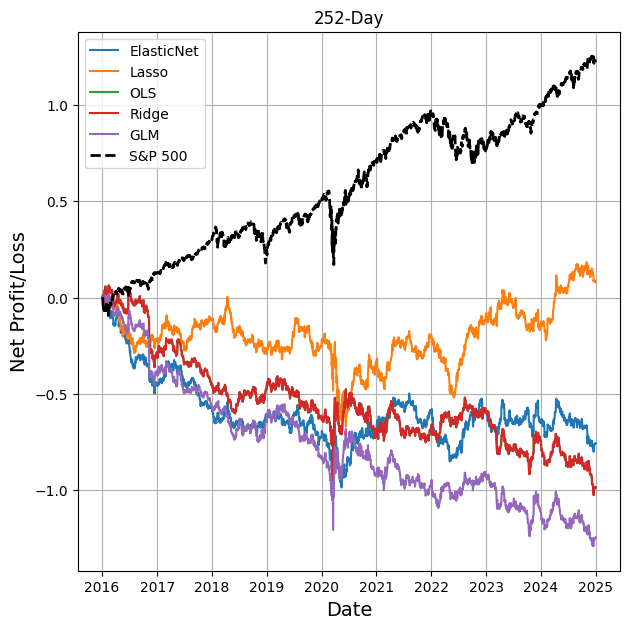

In [6]:
# Plotting returns of linear models vs S&P 500

plt.figure(figsize=(7,7))

# Portfolios
for col in ['ElasticNet', 'Lasso', 'OLS', 'Ridge', 'GLM']:
    plt.plot(portfolio_df.index, portfolio_df[col].cumsum(), label=col, linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("252-Day")
plt.xlabel("Date",fontsize=14)
plt.ylabel("Net Profit/Loss",fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()

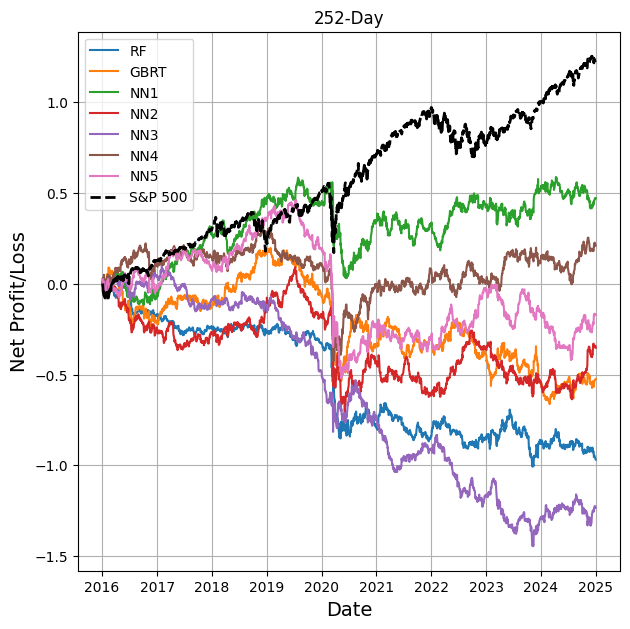

In [7]:
# Plotting returns of non-linear models vs S&P 500

plt.figure(figsize=(7,7))

# Portfolios
for col in ['RF', 'GBRT', 'NN1', 'NN2', 'NN3', 'NN4', 'NN5']:
    plt.plot(portfolio_df.index, portfolio_df[col].cumsum(), label=col, linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("252-Day")
plt.xlabel("Date",fontsize=14)
plt.ylabel("Net Profit/Loss",fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()

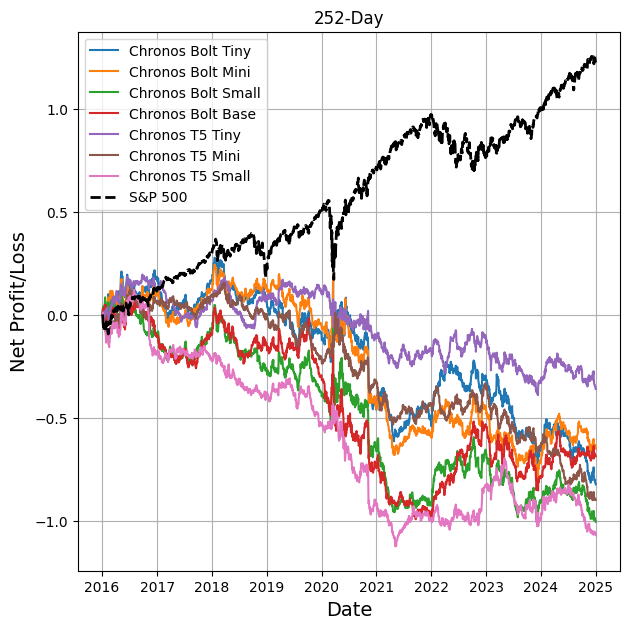

In [8]:
# Plotting returns of chronos models vs S&P 500

plt.figure(figsize=(7,7))
chronos_label = {'y_chr_bolt_tiny': 'Chronos Bolt Tiny', 
         'y_chr_bolt_mini': 'Chronos Bolt Mini', 
         'y_chr_bolt_small': 'Chronos Bolt Small', 
         'y_chr_bolt_base': 'Chronos Bolt Base',
         'y_chr_t5_tiny':'Chronos T5 Tiny', 
         'y_chr_t5_mini':'Chronos T5 Mini', 
         'y_chr_t5_small':'Chronos T5 Small'
         }

# Portfolios
for col in ['y_chr_bolt_tiny', 'y_chr_bolt_mini', 'y_chr_bolt_small', 'y_chr_bolt_base',
            'y_chr_t5_tiny', 'y_chr_t5_mini', 'y_chr_t5_small']:
    plt.plot(portfolio_df.index, portfolio_df[col].cumsum(), label=chronos_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("252-Day")
plt.xlabel("Date",fontsize=14)
plt.ylabel("Net Profit/Loss",fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()


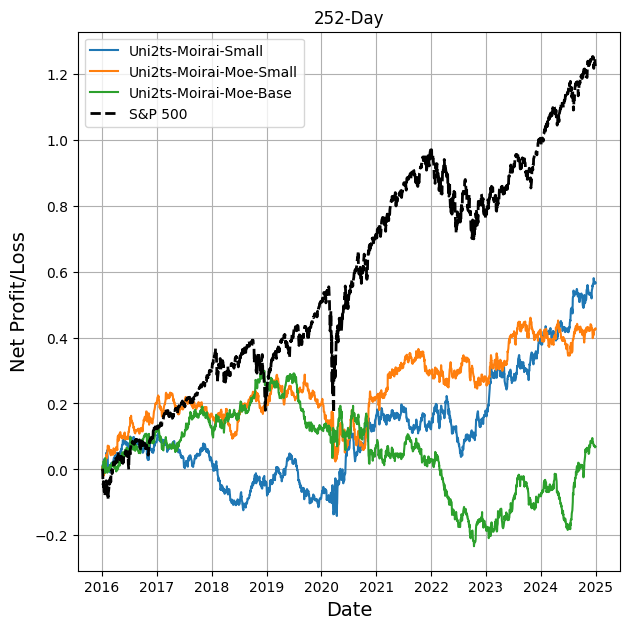

In [9]:
# Plotting returns of uni2ts models vs S&P 500

plt.figure(figsize=(7,7))
uni2ts_label = {"y_moirai_s": "Uni2ts-Moirai-Small",
               "y_moirai_moe_s": "Uni2ts-Moirai-Moe-Small",
               "y_moirai_moe_b": "Uni2ts-Moirai-Moe-Base"
         }

# Portfolios
for col in ['y_moirai_s', 'y_moirai_moe_s', 'y_moirai_moe_b',]:
    plt.plot(portfolio_df.index, portfolio_df[col].cumsum(), label=uni2ts_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("252-Day")
plt.xlabel("Date",fontsize=14)
plt.ylabel("Net Profit/Loss",fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()


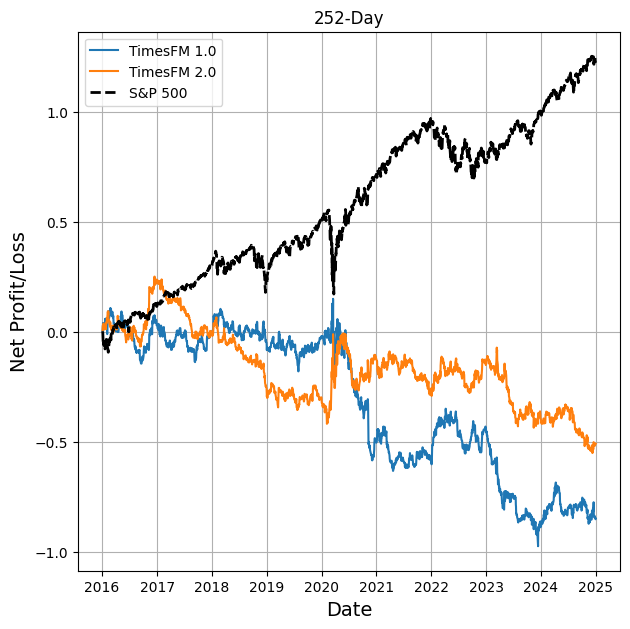

In [10]:
# Plotting returns of TimesFM models vs S&P 500

plt.figure(figsize=(7,7))

timesfm_label = {"y_tfm1": "TimesFM 1.0",
               "y_tfm2": "TimesFM 2.0"
               }

# Portfolios
for col in ['y_tfm1', 'y_tfm2']:
    plt.plot(portfolio_df.index, portfolio_df[col].cumsum(), label=timesfm_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("252-Day")
plt.xlabel("Date",fontsize=14)
plt.ylabel("Net Profit/Loss",fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()

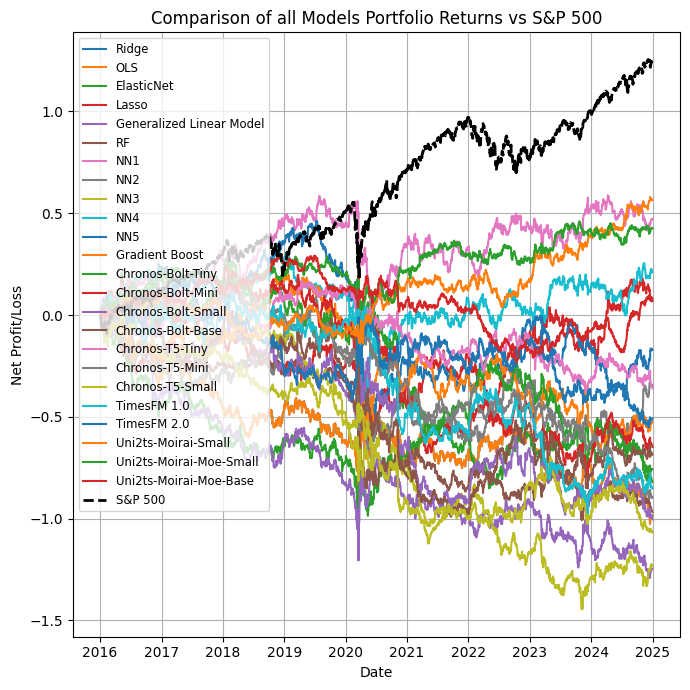

In [11]:
# Plotting returns of all models vs S&P 500

plt.figure(figsize=(7,7))

models_dict = {"OLS": "OLS",
               "Lasso": "Lasso",
               "Ridge": "Ridge",
               "ElasticNet": "ElasticNet",
               "RF": "RF",
               "GLM": "Generalized Linear Model",
               "GBRT": "Gradient Boost",
               "NN1": "NN1",
               "NN2": "NN2",
               "NN3": "NN3",
               "NN4": "NN4",
               "NN5": "NN5",
               "y_chr_bolt_tiny": "Chronos-Bolt-Tiny",
               "y_chr_bolt_mini": "Chronos-Bolt-Mini",
               "y_chr_bolt_small": "Chronos-Bolt-Small",
               "y_chr_bolt_base": "Chronos-Bolt-Base",
               "y_chr_t5_tiny": "Chronos-T5-Tiny",
               "y_chr_t5_mini": "Chronos-T5-Mini",
               "y_chr_t5_small": "Chronos-T5-Small",
               "y_tfm1": "TimesFM 1.0",
               "y_tfm2": "TimesFM 2.0",
               "y_moirai_s": "Uni2ts-Moirai-Small",
               "y_moirai_moe_s": "Uni2ts-Moirai-Moe-Small",
               "y_moirai_moe_b": "Uni2ts-Moirai-Moe-Base"
               }

# Portfolios
for col in model_cols:
    plt.plot(portfolio_df.index, portfolio_df[col].cumsum(), label=models_dict[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("Comparison of all Models Portfolio Returns vs S&P 500")
plt.xlabel("Date")
plt.ylabel("Net Profit/Loss")
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

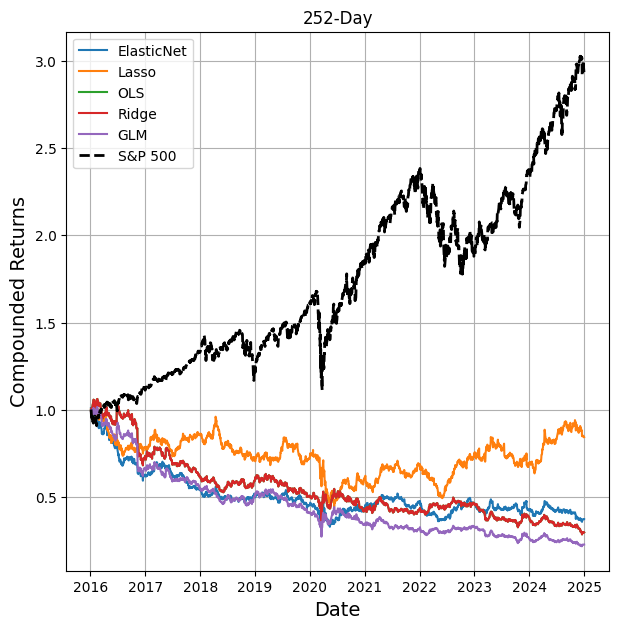

In [12]:
# Plotting compounded returns of linear models vs S&P 500

plt.figure(figsize=(7,7))

# Portfolios
for col in ['ElasticNet', 'Lasso', 'OLS', 'Ridge', 'GLM']:
    plt.plot(portfolio_df.index, (1+portfolio_df[col]).cumprod(), label=col, linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Compounded Returns'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("252-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Compounded Returns", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()

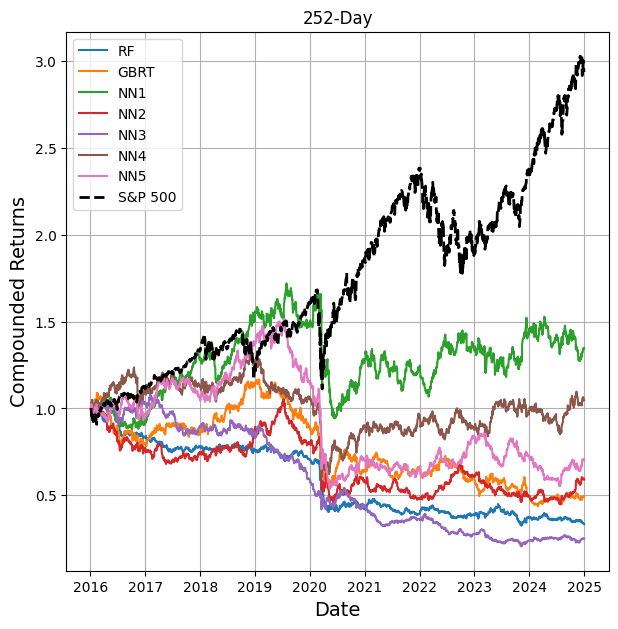

In [13]:
# Plotting returns of non-linear models vs S&P 500

plt.figure(figsize=(7,7))

# Portfolios
for col in ['RF', 'GBRT', 'NN1', 'NN2', 'NN3', 'NN4', 'NN5']:
    plt.plot(portfolio_df.index, (1+portfolio_df[col]).cumprod(), label=col, linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Compounded Returns'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("252-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Compounded Returns", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()

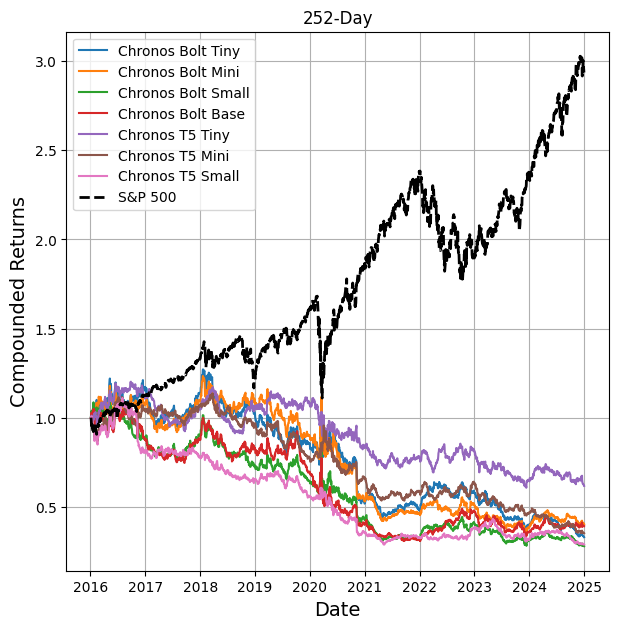

In [14]:
# Plotting returns of chronos models vs S&P 500

plt.figure(figsize=(7,7))
chronos_label = {'y_chr_bolt_tiny': 'Chronos Bolt Tiny', 
         'y_chr_bolt_mini': 'Chronos Bolt Mini', 
         'y_chr_bolt_small': 'Chronos Bolt Small', 
         'y_chr_bolt_base': 'Chronos Bolt Base',
         'y_chr_t5_tiny':'Chronos T5 Tiny', 
         'y_chr_t5_mini':'Chronos T5 Mini', 
         'y_chr_t5_small':'Chronos T5 Small'
         }

# Portfolios
for col in ['y_chr_bolt_tiny', 'y_chr_bolt_mini', 'y_chr_bolt_small', 'y_chr_bolt_base',
            'y_chr_t5_tiny', 'y_chr_t5_mini', 'y_chr_t5_small']:
    plt.plot(portfolio_df.index, (1+portfolio_df[col]).cumprod(), label=chronos_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Compounded Returns'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("252-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Compounded Returns", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()


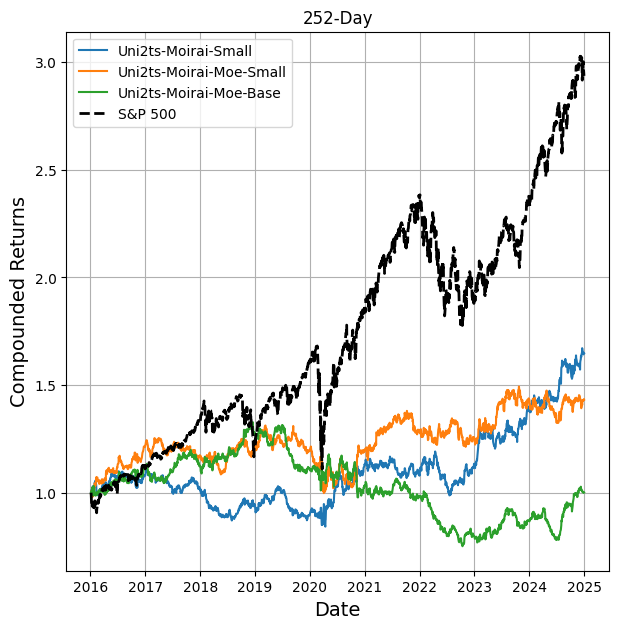

In [15]:
# Plotting returns of uni2ts models vs S&P 500

plt.figure(figsize=(7,7))
uni2ts_label = {"y_moirai_s": "Uni2ts-Moirai-Small",
               "y_moirai_moe_s": "Uni2ts-Moirai-Moe-Small",
               "y_moirai_moe_b": "Uni2ts-Moirai-Moe-Base"
         }

# Portfolios
for col in ['y_moirai_s', 'y_moirai_moe_s', 'y_moirai_moe_b',]:
    plt.plot(portfolio_df.index, (1+portfolio_df[col]).cumprod(), label=uni2ts_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Compounded Returns'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("252-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Compounded Returns", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()


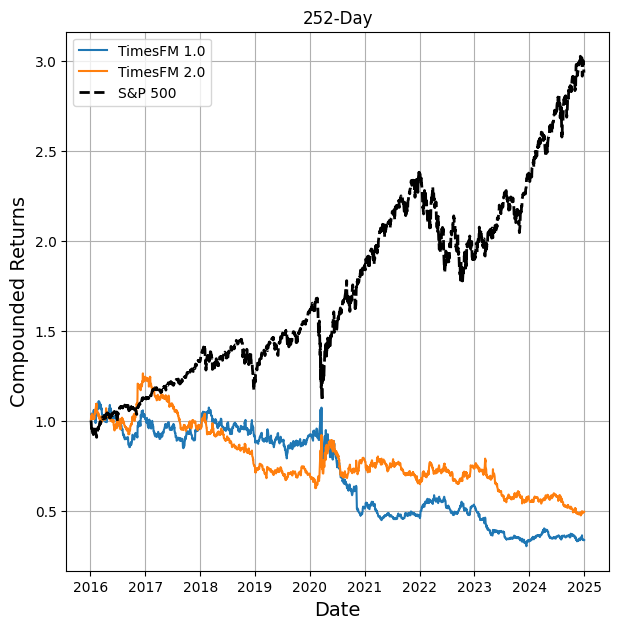

In [16]:
# Plotting returns of TimesFM models vs S&P 500

plt.figure(figsize=(7,7))

timesfm_label = {"y_tfm1": "TimesFM 1.0",
               "y_tfm2": "TimesFM 2.0"
               }

# Portfolios
for col in ['y_tfm1', 'y_tfm2']:
    plt.plot(portfolio_df.index, (1+portfolio_df[col]).cumprod(), label=timesfm_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Compounded Returns'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("252-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Compounded Returns", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()

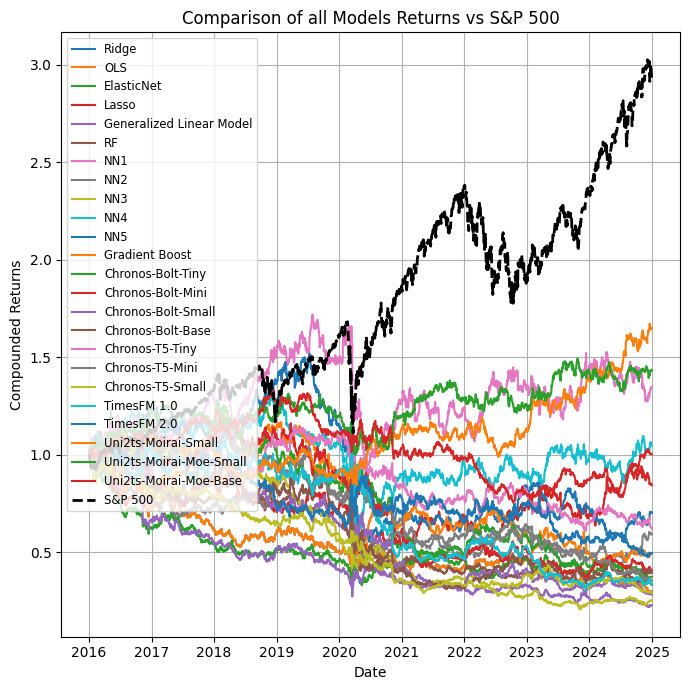

In [17]:
# Plotting returns of all models vs S&P 500

plt.figure(figsize=(7,7))

models_dict = {"OLS": "OLS",
               "Lasso": "Lasso",
               "Ridge": "Ridge",
               "ElasticNet": "ElasticNet",
               "RF": "RF",
               "GLM": "Generalized Linear Model",
               "GBRT": "Gradient Boost",
               "NN1": "NN1",
               "NN2": "NN2",
               "NN3": "NN3",
               "NN4": "NN4",
               "NN5": "NN5",
               "y_chr_bolt_tiny": "Chronos-Bolt-Tiny",
               "y_chr_bolt_mini": "Chronos-Bolt-Mini",
               "y_chr_bolt_small": "Chronos-Bolt-Small",
               "y_chr_bolt_base": "Chronos-Bolt-Base",
               "y_chr_t5_tiny": "Chronos-T5-Tiny",
               "y_chr_t5_mini": "Chronos-T5-Mini",
               "y_chr_t5_small": "Chronos-T5-Small",
               "y_tfm1": "TimesFM 1.0",
               "y_tfm2": "TimesFM 2.0",
               "y_moirai_s": "Uni2ts-Moirai-Small",
               "y_moirai_moe_s": "Uni2ts-Moirai-Moe-Small",
               "y_moirai_moe_b": "Uni2ts-Moirai-Moe-Base"
               }

# Portfolios
for col in model_cols:
    plt.plot(portfolio_df.index, (1+portfolio_df[col]).cumprod(), label=models_dict[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Compounded Returns'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("Comparison of all Models Returns vs S&P 500")
plt.xlabel("Date")
plt.ylabel("Compounded Returns")
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# Function to calculate performance metrics

def performance_metrics(df, column_name):
    returns = df[column_name]

    avg_daily_return = returns.mean()
    ann_return = avg_daily_return * 252
    daily_vol = returns.std()
    ann_vol = daily_vol * np.sqrt(252)
    sharpe = avg_daily_return / daily_vol * np.sqrt(252)

    return {
        'Avg Daily Return': avg_daily_return,
        'Annualized Return': ann_return,
        'Daily Volatility': daily_vol,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe    
        }


In [7]:
metrics_dict = {}

for model in model_cols:
    metrics = performance_metrics(portfolio_df, model)
    metrics_dict[model] = {k: v for k, v in metrics.items()}

# Create summary DataFrame
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index')

metrics_df

,Avg Daily Return,Annualized Return,Daily Volatility,Annualized Volatility,Sharpe Ratio
Ridge,-0.000439,-0.110502,0.014178,0.225075,-0.490958
OLS,-0.000439,-0.110502,0.014178,0.225075,-0.490958
ElasticNet,-0.000337,-0.084892,0.014223,0.225781,-0.375992
Lasso,0.000035,0.008869,0.014896,0.236461,0.037508
GLM,-0.000554,-0.139633,0.014296,0.226934,-0.615302
RF,-0.000431,-0.108514,0.010551,0.167497,-0.647857
NN1,0.000210,0.052933,0.012387,0.196644,0.269179
NN2,-0.000157,-0.039440,0.012362,0.196245,-0.200973
NN3,-0.000549,-0.138281,0.011369,0.180480,-0.766187
NN4,0.000094,0.023602,0.012041,0.191138,0.123481


In [10]:
import pandas as pd
import numpy as np

def calculate_long_short_returns(df, model_col, n=10):
    long_short_returns = []
    for date, group in df.groupby('Date'):
        sorted_group = group.sort_values(model_col, ascending=False)
        no_of_stocks = round((n / 100) * len(sorted_group))
        top = sorted_group.head(no_of_stocks)
        bottom = sorted_group.tail(no_of_stocks)
        avg_return = top['Actual'].mean() - bottom['Actual'].mean()
        long_short_returns.append((date, avg_return))
    return pd.DataFrame(long_short_returns, columns=['Date', 'Returns']).set_index('Date')

def calculate_daily_weights(df, model_col, n=10):
    weights_dict = {}
    for date, group in df.groupby('Date'):
        sorted_group = group.sort_values(model_col, ascending=False)
        no_of_stocks = round((n / 100) * len(sorted_group))
        weights = pd.Series(0, index=sorted_group['PERMNO'])
        weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks
        weights.loc[sorted_group.tail(no_of_stocks)['PERMNO']] = -1 / no_of_stocks
        weights_dict[date] = weights
    weights_df = pd.DataFrame(weights_dict).T.fillna(0)
    return weights_df

def calculate_daily_turnover(weights_df):
    turnover_list = []
    prev_weights = None
    for date, weights in weights_df.iterrows():
        if prev_weights is None:
            turnover = 0
        else:
            turnover = ((weights - prev_weights).abs().sum()) / 2
        turnover_list.append((date, turnover))
        prev_weights = weights
    turnover_df = pd.DataFrame(turnover_list, columns=['Date', 'Turnover']).set_index('Date')
    return turnover_df

def adjust_returns_with_costs(returns_df, turnover_df, transaction_cost_per_trade=0.0015):
    df = returns_df.copy()
    df = df.join(turnover_df, how='left')
    df['Transaction_Cost'] = transaction_cost_per_trade * df['Turnover']
    df['Returns_Adj'] = df['Returns'] - df['Transaction_Cost']
    return df

def performance_metrics(df, return_col='Returns_Adj'):
    returns = df[return_col].dropna()
    avg_daily_return = returns.mean()
    annualized_return = avg_daily_return * 252
    daily_volatility = returns.std()
    annualized_volatility = daily_volatility * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan
    metrics = {
        'Avg Daily Return': avg_daily_return,
        'Annualized Return': annualized_return,
        'Daily Volatility': daily_volatility,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio
    }
    return metrics

# Your list of model columns
model_cols = ['Ridge', 'OLS', 'ElasticNet', 'Lasso', 'GLM', 'RF', 'NN1', 'NN2', 'NN3', 'NN4', 'NN5', 'GBRT', 
              'y_chr_bolt_tiny', 'y_chr_bolt_mini', 'y_chr_bolt_small', 'y_chr_bolt_base',
              'y_chr_t5_tiny', 'y_chr_t5_mini', 'y_chr_t5_small',
              'y_tfm1', 'y_tfm2',
              'y_moirai_s', 'y_moirai_moe_s', 'y_moirai_moe_b']

transaction_cost_per_trade = 0.0002  # 15 bps
n = 10  # top/bottom 10% stocks for long-short

all_metrics = {}
returns_adj_dfs = pd.DataFrame()

for model in model_cols:
    print(f"Processing model: {model}")
    returns_df = calculate_long_short_returns(combined_df, model, n=n)
    weights_df = calculate_daily_weights(combined_df, model, n=n)
    turnover_df = calculate_daily_turnover(weights_df)
    returns_adj_df = adjust_returns_with_costs(returns_df, turnover_df, transaction_cost_per_trade)
    metrics = performance_metrics(returns_adj_df, return_col='Returns_Adj')
    all_metrics[model] = metrics
    returns_adj_dfs[model] = returns_adj_df['Returns_Adj']


# Convert dict of dicts to DataFrame for easier viewing
metrics_df_adj = pd.DataFrame.from_dict(all_metrics, orient='index')
metrics_df_adj = metrics_df_adj.sort_values(by='Sharpe Ratio', ascending=False)

print(metrics_df_adj)


Processing model: Ridge


C:\Users\amaan\AppData\Local\Temp\ipykernel_23196\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: OLS


C:\Users\amaan\AppData\Local\Temp\ipykernel_23196\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: ElasticNet


C:\Users\amaan\AppData\Local\Temp\ipykernel_23196\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: Lasso


C:\Users\amaan\AppData\Local\Temp\ipykernel_23196\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: GLM


C:\Users\amaan\AppData\Local\Temp\ipykernel_23196\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: RF


C:\Users\amaan\AppData\Local\Temp\ipykernel_23196\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: NN1


C:\Users\amaan\AppData\Local\Temp\ipykernel_23196\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: NN2


C:\Users\amaan\AppData\Local\Temp\ipykernel_23196\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: NN3


C:\Users\amaan\AppData\Local\Temp\ipykernel_23196\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: NN4


C:\Users\amaan\AppData\Local\Temp\ipykernel_23196\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: NN5


C:\Users\amaan\AppData\Local\Temp\ipykernel_23196\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: GBRT


C:\Users\amaan\AppData\Local\Temp\ipykernel_23196\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_chr_bolt_tiny


C:\Users\amaan\AppData\Local\Temp\ipykernel_23196\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_chr_bolt_mini


C:\Users\amaan\AppData\Local\Temp\ipykernel_23196\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_chr_bolt_small


C:\Users\amaan\AppData\Local\Temp\ipykernel_23196\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_chr_bolt_base


C:\Users\amaan\AppData\Local\Temp\ipykernel_23196\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_chr_t5_tiny


C:\Users\amaan\AppData\Local\Temp\ipykernel_23196\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_chr_t5_mini


C:\Users\amaan\AppData\Local\Temp\ipykernel_23196\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_chr_t5_small


C:\Users\amaan\AppData\Local\Temp\ipykernel_23196\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_tfm1


C:\Users\amaan\AppData\Local\Temp\ipykernel_23196\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_tfm2


C:\Users\amaan\AppData\Local\Temp\ipykernel_23196\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_moirai_s


C:\Users\amaan\AppData\Local\Temp\ipykernel_23196\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_moirai_moe_s


C:\Users\amaan\AppData\Local\Temp\ipykernel_23196\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


Processing model: y_moirai_moe_b


C:\Users\amaan\AppData\Local\Temp\ipykernel_23196\1056641622.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights.loc[sorted_group.head(no_of_stocks)['PERMNO']] = 1 / no_of_stocks


                  Avg Daily Return  Annualized Return  Daily Volatility  \
NN1                      -0.000123          -0.031102          0.012388   
y_moirai_s               -0.000101          -0.025562          0.007682   
Lasso                    -0.000311          -0.078488          0.014898   
y_moirai_moe_s           -0.000162          -0.040726          0.007691   
NN4                      -0.000255          -0.064365          0.012041   
y_chr_bolt_base          -0.000462          -0.116373          0.014619   
y_chr_bolt_mini          -0.000491          -0.123824          0.014856   
NN5                      -0.000423          -0.106474          0.012623   
y_chr_bolt_tiny          -0.000576          -0.145081          0.015537   
y_tfm2                   -0.000517          -0.130198          0.013104   
y_chr_t5_tiny            -0.000408          -0.102828          0.010243   
y_tfm1                   -0.000573          -0.144281          0.014364   
NN2                      

In [11]:
metrics_df_adj

,Avg Daily Return,Annualized Return,Daily Volatility,Annualized Volatility,Sharpe Ratio
NN1,-0.000123,-0.031102,0.012388,0.196654,-0.158155
y_moirai_s,-0.000101,-0.025562,0.007682,0.121950,-0.209607
Lasso,-0.000311,-0.078488,0.014898,0.236501,-0.331871
y_moirai_moe_s,-0.000162,-0.040726,0.007691,0.122086,-0.333583
NN4,-0.000255,-0.064365,0.012041,0.191138,-0.336745
y_chr_bolt_base,-0.000462,-0.116373,0.014619,0.232077,-0.501442
y_chr_bolt_mini,-0.000491,-0.123824,0.014856,0.235838,-0.525037
NN5,-0.000423,-0.106474,0.012623,0.200379,-0.531361
y_chr_bolt_tiny,-0.000576,-0.145081,0.015537,0.246635,-0.588240
y_tfm2,-0.000517,-0.130198,0.013104,0.208021,-0.625889


In [22]:
# Rename columns to corresponding models

returns_adj_dfs

,Ridge,OLS,ElasticNet,Lasso,GLM,RF,NN1,NN2,NN3,NN4,...,y_chr_bolt_small,y_chr_bolt_base,y_chr_t5_tiny,y_chr_t5_mini,y_chr_t5_small,y_tfm1,y_tfm2,y_moirai_s,y_moirai_moe_s,y_moirai_moe_b
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,-0.003809,-0.003809,0.010649,0.004558,-0.008750,0.000828,-0.000223,-0.012823,0.008320,-0.000480,...,0.007355,0.000674,0.001596,-0.001324,-0.003350,0.000385,0.006905,0.001134,-0.001688,-0.001853
2016-01-05,0.007698,0.007698,-0.015291,-0.013199,0.005868,0.006503,0.005408,0.025559,-0.010937,0.027732,...,0.009547,0.014200,0.002051,-0.007549,0.000060,0.007743,0.017120,0.009331,0.003366,-0.002294
2016-01-06,-0.012313,-0.012313,-0.002495,-0.015569,-0.016199,0.002734,0.004190,-0.003120,0.003088,-0.000573,...,0.014174,0.003378,-0.006429,-0.012760,-0.000484,0.010832,-0.000053,-0.003172,0.002842,-0.002473
2016-01-07,-0.018347,-0.018347,-0.032272,-0.022566,-0.015341,0.010098,-0.003756,-0.030024,-0.011692,-0.015288,...,0.004951,0.008169,-0.001088,0.014355,0.007894,0.017263,-0.003633,-0.018598,-0.016973,0.007853
2016-01-08,-0.004147,-0.004147,-0.002975,-0.006955,-0.001442,-0.005600,-0.013514,-0.004277,-0.000066,0.006300,...,-0.011222,-0.003509,0.008761,-0.002034,-0.004899,-0.005600,-0.001618,-0.011589,0.000410,-0.007477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,-0.008226,-0.008226,0.001437,0.001940,-0.005980,-0.004542,-0.000136,0.001553,0.003024,0.005414,...,0.000221,0.000395,-0.001682,0.007244,-0.011078,0.003692,0.001744,-0.008330,-0.000569,-0.005675
2024-12-26,-0.001160,-0.001160,-0.000515,-0.002272,-0.001797,-0.006107,0.001444,-0.003125,-0.003589,-0.005555,...,-0.007199,-0.007729,-0.005917,-0.000948,-0.003930,-0.005038,-0.003612,-0.002848,-0.004838,-0.004095
2024-12-27,-0.004169,-0.004169,-0.003891,-0.005967,-0.004207,-0.005731,-0.005640,0.000425,-0.004403,-0.008550,...,-0.005765,-0.006961,-0.007414,-0.003758,-0.004162,-0.007796,0.006107,-0.001251,-0.001361,-0.004031


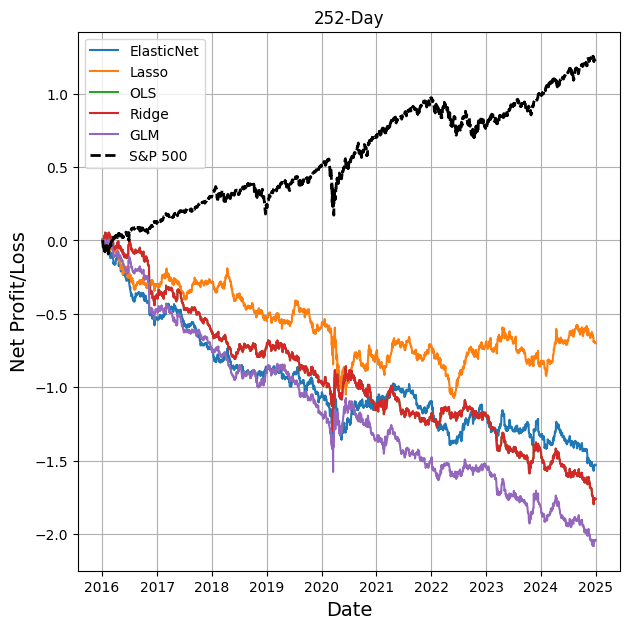

In [12]:
# Plotting returns of linear models vs S&P 500

plt.figure(figsize=(7,7))

# Portfolios
for col in ['ElasticNet', 'Lasso', 'OLS', 'Ridge', 'GLM']:
    plt.plot(returns_adj_dfs.index, returns_adj_dfs[col].cumsum(), label=col, linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("252-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Net Profit/Loss", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()

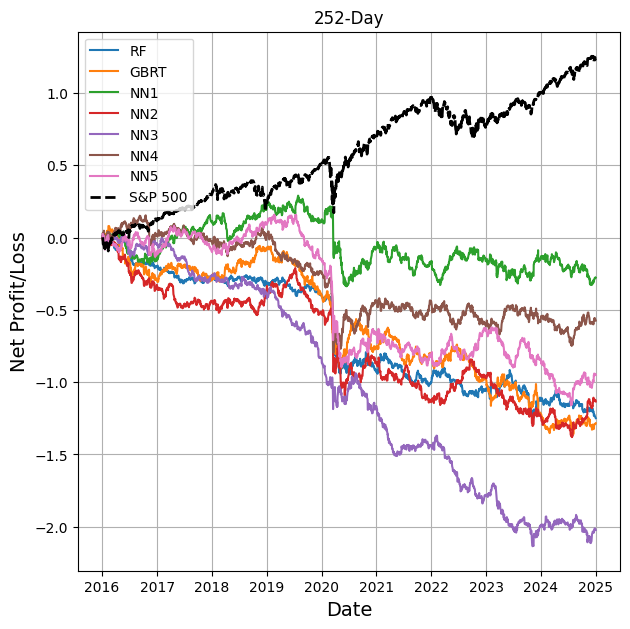

In [13]:
# Plotting returns of non-linear models vs S&P 500

plt.figure(figsize=(7,7))

# Portfolios
for col in ['RF', 'GBRT', 'NN1', 'NN2', 'NN3', 'NN4', 'NN5']:
    plt.plot(returns_adj_dfs.index, returns_adj_dfs[col].cumsum(), label=col, linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("252-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Net Profit/Loss", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()

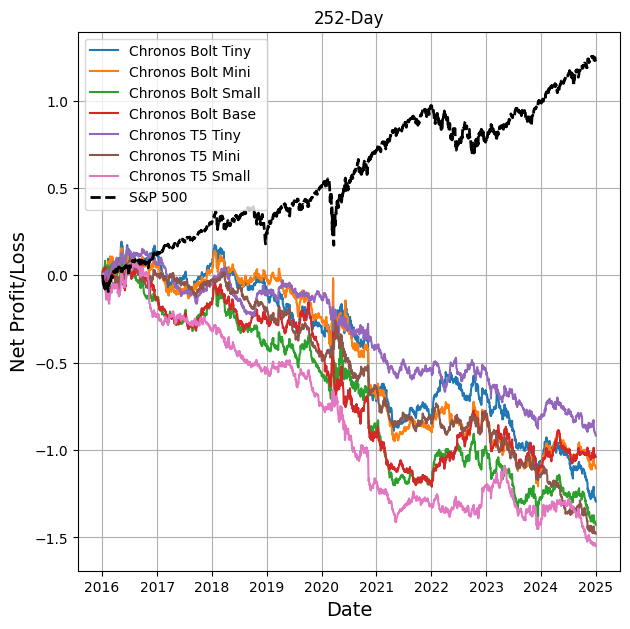

In [14]:
# Plotting returns of chronos models vs S&P 500

plt.figure(figsize=(7,7))
chronos_label = {'y_chr_bolt_tiny': 'Chronos Bolt Tiny', 
         'y_chr_bolt_mini': 'Chronos Bolt Mini', 
         'y_chr_bolt_small': 'Chronos Bolt Small', 
         'y_chr_bolt_base': 'Chronos Bolt Base',
         'y_chr_t5_tiny':'Chronos T5 Tiny', 
         'y_chr_t5_mini':'Chronos T5 Mini', 
         'y_chr_t5_small':'Chronos T5 Small'
         }

# Portfolios
for col in ['y_chr_bolt_tiny', 'y_chr_bolt_mini', 'y_chr_bolt_small', 'y_chr_bolt_base',
            'y_chr_t5_tiny', 'y_chr_t5_mini', 'y_chr_t5_small']:
    plt.plot(returns_adj_dfs.index, returns_adj_dfs[col].cumsum(), label=chronos_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("252-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Net Profit/Loss", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()

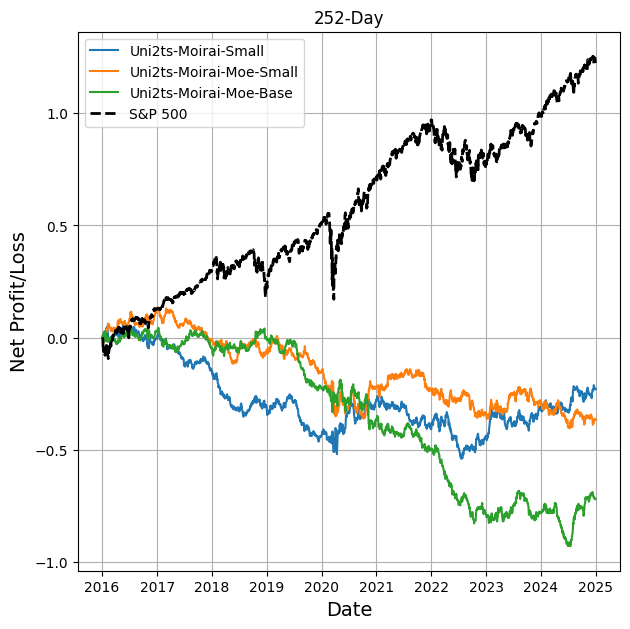

In [15]:
# Plotting returns of uni2ts models vs S&P 500

plt.figure(figsize=(7,7))
uni2ts_label = {"y_moirai_s": "Uni2ts-Moirai-Small",
               "y_moirai_moe_s": "Uni2ts-Moirai-Moe-Small",
               "y_moirai_moe_b": "Uni2ts-Moirai-Moe-Base"
         }

# Portfolios
for col in ['y_moirai_s', 'y_moirai_moe_s', 'y_moirai_moe_b',]:
    plt.plot(returns_adj_dfs.index, returns_adj_dfs[col].cumsum(), label=uni2ts_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("Uni2ts-Moirais Models Portfolio Returns")
plt.title("252-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Net Profit/Loss", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()


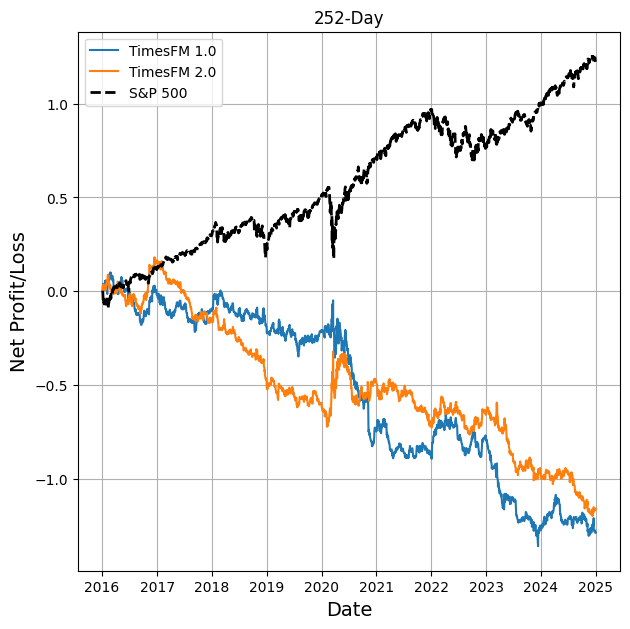

In [17]:
# Plotting returns of uni2ts models vs S&P 500

plt.figure(figsize=(7,7))
timesfm_label = {"y_tfm1": "TimesFM 1.0",
               "y_tfm2": "TimesFM 2.0"
               }

# Portfolios
for col in ['y_tfm1', 'y_tfm2']:
    plt.plot(returns_adj_dfs.index, returns_adj_dfs[col].cumsum(), label=timesfm_label[col], linewidth=1.5)

# S&P 500 baseline
plt.plot(sp500.index, sp500['Cumulative Return'], label='S&P 500', color='black', linewidth=2, linestyle='dashed')
plt.title("252-Day")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Net Profit/Loss", fontsize=14)
plt.legend(loc='upper left', fontsize='medium')
plt.grid(True)
#plt.tight_layout()
plt.show()